In [3]:
#!pip install fastMONAI
from fastMONAI.vision_all import *
from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split

In [4]:
with open('data/SpineSegmentation/dataset.json') as f:
    dataset_json = json.load(f)
training_data = dataset_json['training']

In [5]:
df = pd.DataFrame(training_data)
df.shape

(131, 2)

In [6]:
# split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((117, 2), (14, 2))

In [7]:
os.chdir('/Users/haukebartsch/src/SpineSegmentationAI/data/SpineSegmentation')
os.getcwd()

'/Users/haukebartsch/src/SpineSegmentationAI/data/SpineSegmentation'

In [8]:
med_dataset = MedDataset(img_list=train_df.label.tolist(), dtype=MedMask, max_workers=12)

In [9]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1
0,./labelsTr/1.3.6.1.4.1.45037.f2aaffbfad85d8482612afbc8ceae852ccba633c0c0fa.nii.gz,320,320,17,0.9375,0.9375,4.3999,PSR+,1700767,40033
1,./labelsTr/1.3.6.1.4.1.45037.f708b8ff302d0fd697529b79c0eb0a468c329774f388e.nii.gz,384,384,17,0.7813,0.7813,4.4000,PSR+,2442352,64400
2,./labelsTr/1.3.6.1.4.1.45037.5d7b0eddf0170092a2108ebf93386064c4cb159df1abe.nii.gz,384,384,17,0.7813,0.7813,4.4000,PSR+,2435329,71423
3,./labelsTr/1.3.6.1.4.1.45037.c34f076c0c8564ca87d37a308d4fe1dc73fd328c65b80.nii.gz,384,384,17,0.7812,0.7813,4.4000,PSR+,2445320,61432
4,./labelsTr/1.3.6.1.4.1.45037.e6ab5cdaa978e3f2d32f4bc012487371b788345ab0b44.nii.gz,384,384,17,0.7812,0.7812,4.4000,PSR+,2440138,66614


In [10]:
data_info_df = med_dataset.summary()

In [11]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
4,384,384,17,0.7812,0.7812,4.4,PSR+,./labelsTr/1.3.6.1.4.1.45037.0061b3c200bb6b31566b6861abb49c8f668fe79000805.nii.gz,59
5,384,384,17,0.7812,0.7813,4.4,PSR+,./labelsTr/019c3523ce0e4048407dbce0946a5c6559665398d8051ffbc6053f228e0e8586.nii.gz,18
6,384,384,17,0.7813,0.7812,4.4,PSR+,./labelsTr/1.3.6.1.4.1.45037.2bce302276ae4a8fd5a0ef292e7de24b4270270c73121.nii.gz,18
8,384,384,17,0.7813,0.7813,4.4,PSR+,./labelsTr/1.3.6.1.4.1.45037.3ec342080cf70e4076cc71c5014e76afd85f30086d2bb.nii.gz,7
2,320,320,17,0.9375,0.9375,4.4,PSR+,./labelsTr/1.3.6.1.4.1.45037.3eb8a5011f2120b641058c4a540a5745422b1154f81f3.nii.gz,6


In [12]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([0.7812, 0.7812, 4.4], False)

In [13]:
bs=4
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[384.0, 384.0, 19.0]

The suggestion above shows that there are few images in the z-dimension (19). This is due to the slice thickness, in effect we have a series of thick 2D images in the sagittal 
plane, not a true isotrophic volume. We will PadOrCrop that dimension to some close power of 2 (32).

In [14]:
size=[384,384,32]
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5)]

In [15]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock),splitter=RandomSplitter(valid_pct=0.1, seed=42), get_x=ColReader('image'), get_y=ColReader('label'), item_tfms=item_tfms, reorder=reorder, resample=resample)

In [16]:
dls = dblock.dataloaders(train_df, bs=bs)

In [17]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(106, 11)

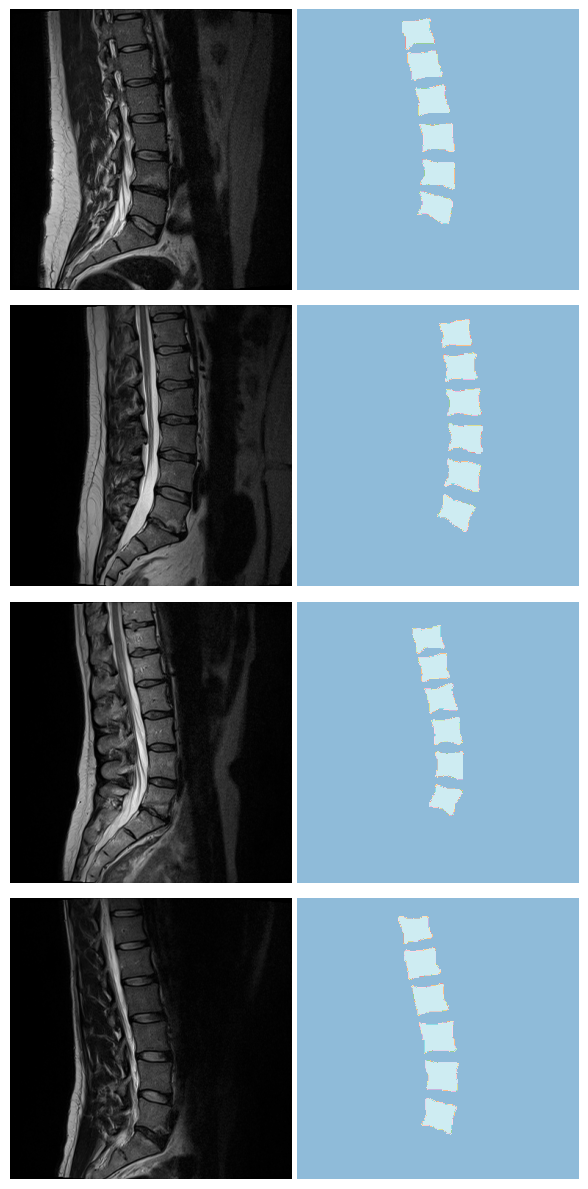

In [18]:
dls.show_batch(anatomical_plane=2)

In [19]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss

Training is done on the CPU, even if its slow. Currently my M2 chip AI chip is not supported as the torch device "mps" cannot do 3D convolutions.

In [22]:
model = UNet(spatial_dims=3, in_channels=1, out_channels=1, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2).to(torch.device("cpu"))
model = model.model


In [23]:
loss_func = CustomLoss(loss_func=DiceLoss(sigmoid=True))

In [24]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=binary_dice_score)

SuggestedLRs(valley=0.013182567432522774)

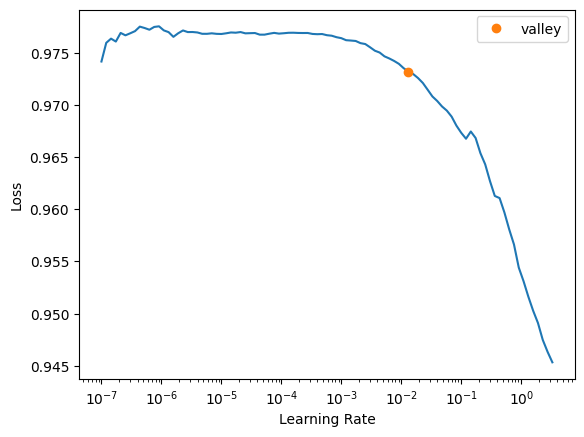

In [25]:
learn.dls.cpu()
learn.lr_find()

In [26]:
lr = 0.0131825674

In [27]:
learn.fit_flat_cos(200, lr)

epoch,train_loss,valid_loss,binary_dice_score,time
0,0.965923,0.955801,0.137019,05:23
1,0.957045,0.950611,0.200464,06:22
2,0.950827,0.944393,0.214565,06:33
3,0.942970,0.925561,0.160348,06:17
4,0.925934,0.874688,0.206098,06:33
5,0.888719,0.806378,0.290960,06:37
6,0.827697,0.701973,0.380061,05:59
7,0.734574,0.533868,0.530387,05:58
8,0.616662,0.375770,0.658292,05:43
9,0.497010,0.253976,0.752131,06:39


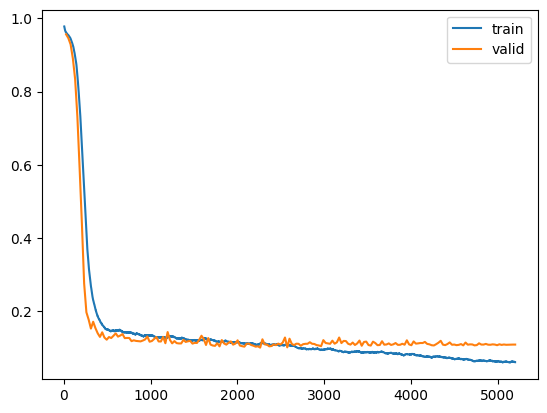

In [24]:
learn.recorder.plot_loss()

In [25]:
learn.save('spine-model')

Path('models/spine-model.pth')

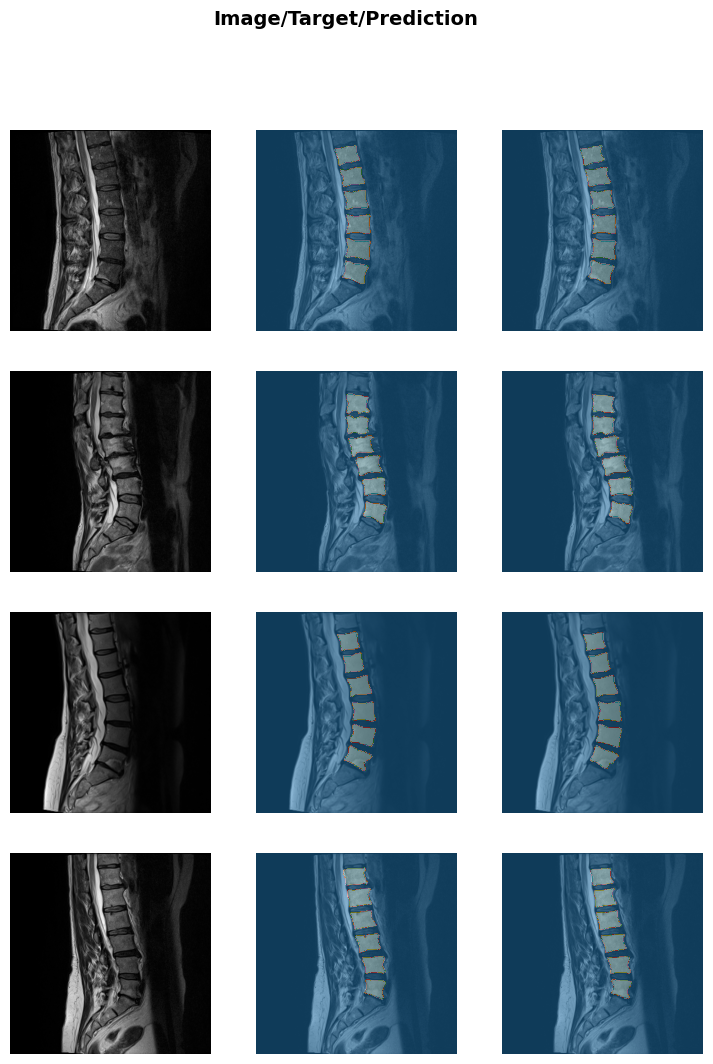

In [26]:
learn.show_results(anatomical_plane=2)

In [28]:
# export learner
store_variables(pkl_fn='vars.pkl', size=size, reorder=reorder, resample=resample)

In [29]:
learn.export('spine_model.pkl')

For inference see the SpineSegmentationInference.py script.